In [2]:
import numpy as np
from prfpy.stimulus import PRFStimulus2D
from prfpy.model import Iso2DGaussianModel, DoG_Iso2DGaussianModel
from prfpy.fit import Iso2DGaussianFitter, DoG_Iso2DGaussianFitter, CSS_Iso2DGaussianFitter

import os

from os.path import join as opj

import scipy.io

import nibabel as nib

import matplotlib.pyplot as plt

import nilearn
from nilearn import plotting, datasets, image

from nilearn.input_data import NiftiMasker
# from nilearn import image

import pickle

/home/mayajas/.local/lib/python3.8/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
/home/mayajas/.local/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
# if os.getcwd() != '/home/mayaaj90/projects/project-00-7t-pipeline-dev/code/analysis-scripts/python':
#     os.chdir('/home/mayaaj90/projects/project-00-7t-pipeline-dev/code/analysis-scripts/python')

In [2]:
os.getcwd()

'/home/mayajas/Documents/project-00-7t-pipeline-dev/code/notebooks'

In [4]:
# n_procs = int(os.getenv('OMP_NUM_THREADS'))   
# print(n_procs)

In [5]:
sub_id       = 0 #sys.argv[1]
hem_id       = 0 #sys.argv[2]

subject_list = ['sub-01','sub-02','sub-03','sub-04']
hem_list     = ['lh','rh']

proj_dir     = '/home/mayajas/scratch/project-00-7t-pipeline-dev/'
data_dir     = opj(proj_dir,'output','func','sliceTimeCorr',
                   '_subject_id_'+subject_list[sub_id])
bar1_file    = opj(data_dir,'_sess_id_task-bar_run-01_sess_nr_0_sess_nvol_124','atask-bar_run-01_roi_warp4D.nii')
bar2_file    = opj(data_dir,'_sess_id_task-bar_run-02_sess_nr_1_sess_nvol_124','atask-bar_run-02_roi_warp4D.nii')

meanFunc_file= opj(proj_dir,'output','func','meanFunc',
                   '_subject_id_'+subject_list[sub_id],'merged_func_mcf.nii_mean_reg.nii')


prfpy_output_dir = opj(proj_dir,'output','prfpy_DoG_Iso2DGaussianModel',subject_list[sub_id])
if not os.path.isdir(prfpy_output_dir):
    os.makedirs(prfpy_output_dir)
    
GM_file      = opj(prfpy_output_dir,
                   hem_list[hem_id]+'_GM_funcSpace.nii')
occ_file     = opj(prfpy_output_dir,
                  'funcSpaceOccipitalMask.nii')
    
grid_fit_file      = opj(prfpy_output_dir,hem_list[hem_id]+'_grid_fit.pckl')
iterative_fit_file = opj(prfpy_output_dir,hem_list[hem_id]+'_iterative_fit.pckl')
pRF_param_file     = opj(prfpy_output_dir,hem_list[hem_id]+'_pRF_params.pckl')

#/home/mayajas/scratch/project-00-7t-pipeline-dev/manualcorr/func/_subject_id_sub-01
#output/func/sliceTimeCorr/_subject_id_sub-01/_sess_id_task-bar_run-01_sess_nr_0_sess_nvol_12

In [6]:
GM_file

'/home/mayajas/scratch/project-00-7t-pipeline-dev/output/prfpy_DoG_Iso2DGaussianModel/sub-01/lh_GM_funcSpace.nii'

In [7]:
occ_file

'/home/mayajas/scratch/project-00-7t-pipeline-dev/output/prfpy_DoG_Iso2DGaussianModel/sub-01/funcSpaceOccipitalMask.nii'

# Creating stimulus object

Get stimulus aperture

In [9]:
project_dir  = '/home/mayajas/Documents/project-00-7t-pipeline-dev/'
Ap_file      = os.path.join(project_dir,'code','stim-scripts','apertures','stimulus_bar.mat')

mat          = scipy.io.loadmat(Ap_file)

In [10]:
np.shape(mat["stim"])

(200, 200, 120)

Define screen size, distance, TR and aperture matrix

In [11]:
screen_size_cm     = 12.0
screen_distance_cm = 52.0
TR                 = 3.0
design_matrix      = mat["stim"]

In [12]:
import math 
max_ecc = math.atan(screen_size_cm/screen_distance_cm)/2
max_ecc_deg = math.degrees(max_ecc)

print("Max eccentricity of stimulus is "+str(round(max_ecc_deg,2)))

Max eccentricity of stimulus is 6.5


Define stimulus object

In [13]:
prf_stim = PRFStimulus2D(screen_size_cm=screen_size_cm,
                             screen_distance_cm=screen_distance_cm,
                             design_matrix=design_matrix,
                             TR=TR)

# Gaussian model fit

Get func data

In [17]:
bar1 = nib.load(bar1_file)
bar2 = nib.load(bar2_file)

# bar1_data = bar1.get_fdata()
# bar2_data = bar2.get_fdata()

In [18]:
occ = nib.load(occ_file)

In [19]:
GM = nib.load(GM_file)

In [20]:
meanFunc = nib.load(meanFunc_file)

Do masking

In [23]:
mask = image.math_img("np.logical_and(img1, img2)", img1=occ, img2=GM)

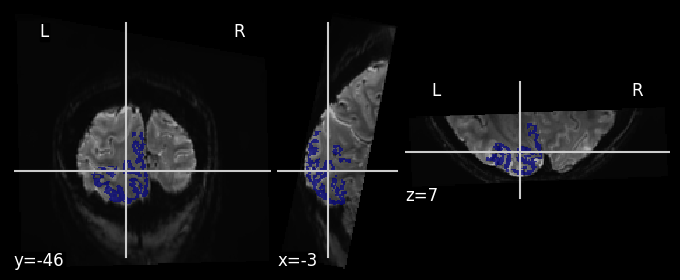

In [24]:
# Visualize it as an ROI
from nilearn.plotting import plot_roi
plot_roi(mask,meanFunc)

In [30]:
detrend     = True
standardize = True
low_pass    = 0.10
high_pass   = 0.01
verbose     = True
t_r         = TR

In [31]:
masker = NiftiMasker(mask_img=mask, detrend=detrend, standardize=standardize, t_r=t_r,
                    low_pass=low_pass, high_pass=high_pass, verbose=verbose)

In [32]:
masked_bar1 = masker.fit_transform(bar1)
masked_bar2 = masker.fit_transform(bar2)

[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/home/mayajas/scratch/project-00-7t-pipeline-dev/output/func/sliceTimeCorr/_subject_id_sub-01/_sess_id_task-bar_run-01_sess_nr_0_sess_nvol_124/atask-bar_run-01_roi_warp4D.nii')
[NiftiMasker.transform_single_imgs] Resampling images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/home/mayajas/scratch/project-00-7t-pipeline-dev/output/func/sliceTimeCorr/_subject_id_sub-01/_sess_id_task-bar_run-02_sess_nr_1_sess_nvol_124/atask-bar_run-02_roi_warp4D.nii')
[NiftiMasker.transform_single_imgs] Resampling images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


In [33]:
masked_bar1 = np.rot90(masked_bar1)
masked_bar2 = np.rot90(masked_bar2)

In [41]:
# masked_meanFunc = masker.fit_transform(meanFunc)

# masked_meanFunc = np.squeeze(masked_meanFunc)

In [34]:
np.shape(masked_bar1)

(19078, 120)

In [35]:
#np.shape(masked_meanFunc)

In [36]:
np.shape(masked_bar1) == np.shape(masked_bar2)

True

Plot timecourses

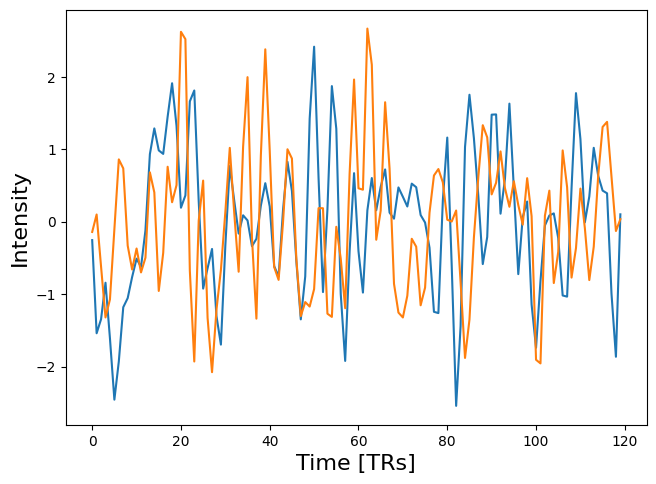

In [37]:
# And now plot a few of these
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 5))
plt.plot(np.rot90(masked_bar1[:1, :]))
plt.plot(np.rot90(masked_bar2[:1, :]))
plt.xlabel('Time [TRs]', fontsize=16)
plt.ylabel('Intensity', fontsize=16)
#plt.xlim(0, 150)
plt.subplots_adjust(bottom=.12, top=.95, right=.95, left=.12)

Average data from 2 sessions

In [38]:
bar_data = (masked_bar1 + masked_bar2)/2

Plot averaged data

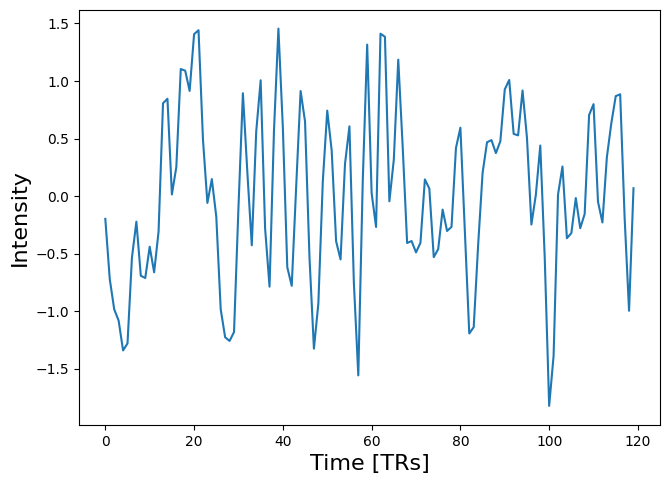

In [39]:
# And now plot a few of these
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 5))
plt.plot(np.rot90(bar_data[:1, :]))
plt.xlabel('Time [TRs]', fontsize=16)
plt.ylabel('Intensity', fontsize=16)
#plt.xlim(0, 150)
plt.subplots_adjust(bottom=.12, top=.95, right=.95, left=.12)

## Creating Gaussian model and fitter objects

Load previous Iso2DGaussianModel fit

In [44]:
iterative_fit_file

'/home/mayajas/scratch/project-00-7t-pipeline-dev/output/prfpy_DoG_Iso2DGaussianModel/sub-01/lh_iterative_fit.pckl'

In [45]:
f = open(iterative_fit_file,'rb')
gf = pickle.load(f)

In [46]:
hrf                = None     # string, list or numpy.ndarray, optional
                              # HRF shape for this Model.
                              # Can be 'direct', which implements nothing (for eCoG or later convolution),
                              # a list or array of 3, which are multiplied with the three spm HRF basis functions,
                              # and an array already sampled on the TR by the user.
                              # (the default is None, which implements standard spm HRF)
filter_predictions = False    # boolean, optional
                              # whether to high-pass filter the predictions, default False
filter_type        = 'sg'

sg_filter_window_length = 201
sg_filter_polyorder     = 3

filter_params      = {'window_length':sg_filter_window_length, 
                      'polyorder':sg_filter_polyorder}
normalize_RFs      = False    # whether or not to normalize the RF volumes (generally not needed).

# Input parameters of Iso2DGaussianFitter
n_jobs             = 1  # int, optional
                              # number of jobs to use in parallelization (iterative search), by default 1
fit_hrf            = False    # boolean, optional
                              # Whether or not to fit two extra parameters for hrf derivative and
                              # dispersion. The default is False.

In [47]:
gg_dog = DoG_Iso2DGaussianModel(stimulus=prf_stim,
                                filter_predictions=filter_predictions,
                                filter_type=filter_type,
                                filter_params=filter_params,
                                normalize_RFs=normalize_RFs)


In [48]:
gf_dog = DoG_Iso2DGaussianFitter(data=bar_data, model=gg_dog, n_jobs=n_jobs, fit_css=False,
                                previous_gaussian_fitter=gf)

In [62]:
grid_nr = 30
max_ecc_size = 15
sizes, eccs, polars = max_ecc_size * np.linspace(0.25,1,grid_nr)**2, \
                    max_ecc_size * np.linspace(0.1,1,grid_nr)**2, \
                        np.linspace(0, 2*np.pi, grid_nr)

In [61]:
grid_nr = 30
max_ecc_size = round(max_ecc_deg,2)
size_grid, ecc_grid, polar_grid = max_ecc_size * np.linspace(0.25,1,grid_nr)**2, \
                    max_ecc_size * np.linspace(0.1,1,grid_nr)**2, \
                        np.linspace(0, 2*np.pi, grid_nr)

In [65]:
sizes

array([ 0.9375    ,  1.14149822,  1.36556183,  1.60969084,  1.87388526,
        2.15814507,  2.46247027,  2.78686088,  3.13131688,  3.49583829,
        3.88042509,  4.28507729,  4.70979489,  5.15457788,  5.61942628,
        6.10434007,  6.60931926,  7.13436385,  7.67947384,  8.24464923,
        8.82989001,  9.4351962 , 10.06056778, 10.70600476, 11.37150713,
       12.05707491, 12.76270809, 13.48840666, 14.23417063, 15.        ])

In [68]:
grid_nr = 30
max_ecc_size = round(max_ecc_deg,2)
surround_amplitude_grid, surround_size_grid = np.linspace(0.25,1,grid_nr)**2, \
                    max_ecc_size*4 * np.linspace(0.1,1,grid_nr)**2

In [70]:
surround_size_grid

array([ 0.26      ,  0.44642093,  0.68292509,  0.96951249,  1.30618312,
        1.69293698,  2.12977408,  2.61669441,  3.15369798,  3.74078478,
        4.37795482,  5.06520809,  5.80254459,  6.58996433,  7.4274673 ,
        8.31505351,  9.25272295, 10.24047562, 11.27831153, 12.36623068,
       13.50423306, 14.69231867, 15.93048751, 17.2187396 , 18.55707491,
       19.94549346, 21.38399524, 22.87258026, 24.41124851, 26.        ])

In [71]:
gf_dog.grid_fit(surround_amplitude_grid = surround_amplitude_grid,
                surround_size_grid = surround_size_grid,
                rsq_threshold=0.0005, verbose=True, gaussian_params=gf.gridsearch_params)

Each batch contains approx. 1908 voxels.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/mayajas/Documents/programs/prfpy-main/prfpy/model.py:680: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if current_hrf == 'direct':


KeyboardInterrupt: 

In [ ]:
help(gf.iter)

In [49]:
gf_dog.iterative_fit(rsq_threshold=0.0005, verbose=True, starting_params=gf.iterative_search_params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Performing unbounded, unconstrained minimization (Powell).


TypeError: return_prediction() missing 2 required positional arguments: 'srf_amplitude' and 'srf_size'

In [3]:
help(DoG_Iso2DGaussianFitter.iterative_fit)

Help on function iterative_fit in module prfpy.fit:

iterative_fit(self, rsq_threshold, verbose=False, starting_params=None, bounds=None, args={}, constraints=[], xtol=0.0001, ftol=0.001)
    Iterative_fit for models building on top of the Gaussian. Does not need to be
    redefined for new models. It is sufficient to define either
    `insert_new_model_params` or `grid_fit`, in a new model Fitter class,
    or provide explicit `starting_params`.
    
    
    Parameters
    ----------
    rsq_threshold : float
        Rsq threshold for iterative fitting. Must be between 0 and 1.
    verbose : boolean, optional
        Whether to print output. The default is False.
    starting_params : ndarray of size [units, model_params +1], optional
        Explicit start for minimization. The default is None.
    bounds : list of tuples, optional
        Bounds for parameter minimization. The default is None.
    args : dictionary, optional
        Further arguments passed to iterative_search. The

Grid fit parameters

In [32]:
grid_nr = 30
max_ecc_size = 2*round(max_ecc_deg,2)
size_grid, ecc_grid, polar_grid = max_ecc_size * np.linspace(0.25,1,grid_nr)**2, \
                    max_ecc_size * np.linspace(0.1,1,grid_nr)**2, \
                        np.linspace(0, 2*np.pi, grid_nr)
pos_prfs_only=False

In [33]:
size_grid

array([ 0.8125    ,  0.98929845,  1.18348692,  1.3950654 ,  1.62403389,
        1.87039239,  2.1341409 ,  2.41527943,  2.71380797,  3.02972652,
        3.36303508,  3.71373365,  4.08182224,  4.46730083,  4.87016944,
        5.29042806,  5.72807669,  6.18311534,  6.655544  ,  7.14536266,
        7.65257134,  8.17717004,  8.71915874,  9.27853746,  9.85530618,
       10.44946492, 11.06101367, 11.68995244, 12.33628121, 13.        ])

Iterative fit parameters

In [34]:
rsq_threshold = 0.0005      # float
                            # Rsq threshold for iterative fitting. Must be between 0 and 1.
verbose       = True        # boolean, optional
                            # Whether to print output. The default is False.
# gauss_bounds  = 
# constraints   =
# xtol          =
# ftol          =

Check if grid/iterative fit were run; if not, run them

In [33]:
try:
    try:
        # if pRF parameters have already been extracted
        print("Checking if pRF parameters have already been extracted...")
        f = open(pRF_param_file,'rb')
        print("PRF parameters good to go!")
    except IOError:
        try:
            # if iterative search has already been run
            print("pRF parameters not yet extracted")
            print("Checking if grid and iterative fits have already been run...")
            f = open(iterative_fit_file,'rb')
            gf = pickle.load(f)

            print("Grid and iterative fits have already been run.")
        except IOError:
            print("Iterative fit not yet run.")
            print("Checking if grid fit has been run...")
            # if grid search has already been run
            f = open(grid_fit_file,'rb')
            gf = pickle.load(f)

            print("Grid fit has already been run")

            print("Now running iterative fit")

            gf.iterative_fit(rsq_threshold=rsq_threshold, verbose=verbose)

            f = open(iterative_fit_file, 'wb')
            pickle.dump(gf, f)

except IOError:
    print("Neither grid nor iterative fit yet run...")
    print("Now running grid fit.")
    
    gf.grid_fit(ecc_grid=ecc_grid,
                    polar_grid=polar_grid,
                    size_grid=size_grid,
                    verbose=verbose,
                    n_batches=n_procs)
    f = open(grid_fit_file, 'wb')
    pickle.dump(gf, f)
    f.close()
          
    print("Finished running grid fit.")
    print("Now running iterative fit.")
          
    gf.iterative_fit(rsq_threshold=rsq_threshold, verbose=verbose)

    f = open(iterative_fit_file, 'wb')
    pickle.dump(gf, f)
finally:
    f.close()


Checking if pRF parameters have already been extracted...
PRF parameters good to go!


## Plot results

Extract parameters from iterative fit result

In [34]:
try:
    # if pRF parameters have already been extracted
    f = open(pRF_param_file,'rb')
    x, y, sigma, total_rsq, polar, ecc = pickle.load(f)
except IOError:
    x=gf.iterative_search_params[:,0]
    y=gf.iterative_search_params[:,1]
    sigma=gf.iterative_search_params[:,2]
    total_rsq = gf.iterative_search_params[:,-1]
    
    #Calculate polar angle and eccentricity maps
    polar = np.angle(x + 1j*y)
    ecc = np.abs(x + 1j*y)
    
    f = open(pRF_param_file, 'wb')
    pickle.dump([x, y, sigma, total_rsq, polar, ecc], f)
finally:
    f.close()

In [35]:
max(ecc)

321628.5030131897

In [36]:
x.shape

(69270,)

In [38]:
type(x)

numpy.ndarray

In [40]:
#np.squeeze(masked_meanFunc).shape

(69270,)

In [39]:
type(masked_meanFunc)

numpy.ndarray

Transform back to brain space

In [44]:
unmasked_x     = masker.inverse_transform(x) 
unmasked_y     = masker.inverse_transform(y) 
unmasked_sigma = masker.inverse_transform(sigma) 
unmasked_pol   = masker.inverse_transform(polar) 
unmasked_ecc   = masker.inverse_transform(ecc) 
unmasked_rsq   = masker.inverse_transform(total_rsq) 


In [45]:
#unmasked_meanFunc     = masker.inverse_transform(masked_meanFunc) 


(array([ 11.,  28.,  60.,  80.,  92., 127., 130., 158., 134., 137., 150.,
        172., 191., 200., 173., 181., 190., 181., 172., 222., 223., 198.,
        195., 242., 234., 206., 202., 196., 226., 233., 181., 159., 178.,
        196., 191., 185., 139., 193., 215., 201., 154., 131., 150., 166.,
        187., 170., 147., 134., 137., 178., 192., 168., 138., 108., 106.,
        128., 178., 154., 156., 115.,  84., 100., 161., 170., 159., 109.,
         88.,  64.,  76., 102., 160., 203., 129.,  63.,  42.,  49.,  88.,
        126., 188., 153.,  85.,  38.,  28.,  23.,  58.,  97., 179., 159.,
         59.,  26.,  16.,  12.,  23.,  75., 165., 181.,  48.,  12.,   6.,
          7.]),
 array([0.        , 0.06497308, 0.12994617, 0.19491925, 0.25989234,
        0.32486542, 0.3898385 , 0.45481159, 0.51978467, 0.58475776,
        0.64973084, 0.71470392, 0.77967701, 0.84465009, 0.90962318,
        0.97459626, 1.03956934, 1.10454243, 1.16951551, 1.2344886 ,
        1.29946168, 1.36443476, 1.42940785, 1.

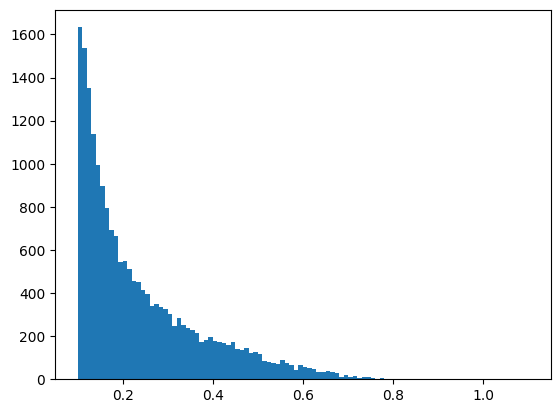

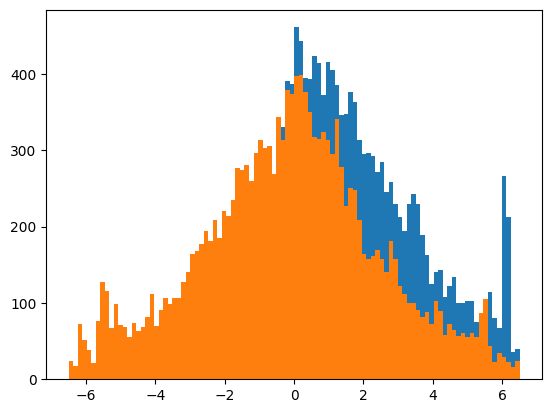

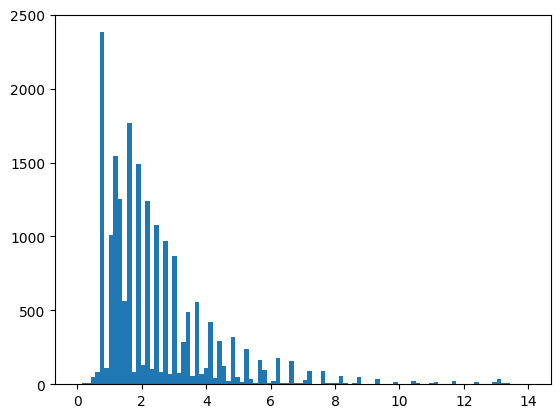

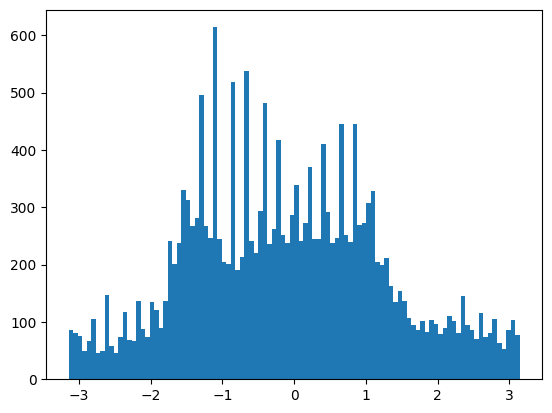

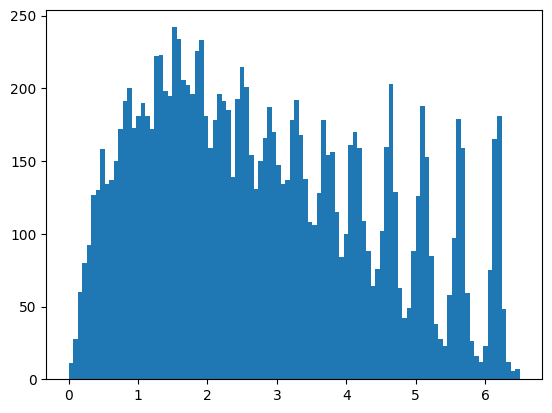

In [53]:
plt.hist(total_rsq, bins=100, range=[0.1,1.1]);
plt.figure()
plt.hist(x[total_rsq>0.1], bins=100, range=[-max_ecc_deg,max_ecc_deg]);
plt.hist(y[total_rsq>0.1], bins=100, range=[-max_ecc_deg,max_ecc_deg]);
plt.figure()
plt.hist(sigma[total_rsq>0.1],bins=100, range=[0,14])
plt.figure()
plt.hist(polar[total_rsq>0.1],bins=100, range=[-np.pi,np.pi])
plt.figure()
plt.hist(ecc[total_rsq>0.1],bins=100, range=[0,max_ecc_deg])
#plt.hist(gfS.iterative_search_params[:,2], bins=100, range=[0,20]);

#plt.stairs(counts, bins)

Visualize x

In [54]:
max(ecc[total_rsq>0.1])

321628.5030131897

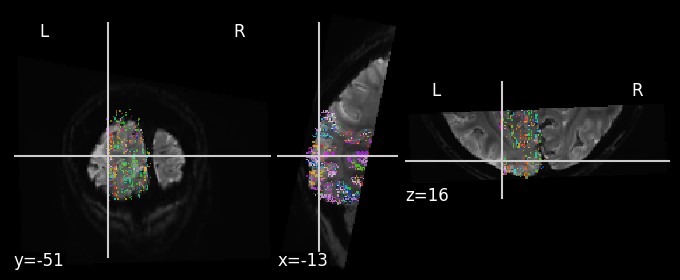

In [55]:
plot_roi(unmasked_pol,meanFunc)

Save Nifti images

In [56]:
nib.save(unmasked_x, opj(prfpy_output_dir, hem_list[hem_id]+'_x.nii'))  
nib.save(unmasked_y, opj(prfpy_output_dir, hem_list[hem_id]+'_y.nii'))  
nib.save(unmasked_sigma, opj(prfpy_output_dir, hem_list[hem_id]+'_sigma.nii'))  
nib.save(unmasked_rsq, opj(prfpy_output_dir, hem_list[hem_id]+'_rsq.nii'))  
nib.save(unmasked_pol, opj(prfpy_output_dir, hem_list[hem_id]+'_pol.nii'))  
nib.save(unmasked_ecc, opj(prfpy_output_dir, hem_list[hem_id]+'_ecc.nii'))  

In [46]:
#nib.save(unmasked_meanFunc, opj(prfpy_output_dir, 'testing_meanFunc.nii'))  


In [ ]:
# min(x)

In [ ]:
# try:
#     # if iterative search has already been run
#     f = open('iterative_fit.pckl','rb')
#     gf = pickle.load(f)
    
#     print("Iterative fit has already been run")
    

# except IOError:
#     print("Running iterative fit")
    
#     gf.iterative_fit(rsq_threshold=rsq_threshold, verbose=verbose)
    
#     f = open('iterative_fit.pckl', 'wb')
#     pickle.dump(gf, f)
#     f.close()
# finally:
#     f.close()



In [ ]:
help(Iso2DGaussianModel)

## Crossvalidate

In [ ]:
help(gf.crossvalidate_fit)

In [ ]:
# gf.crossvalidate_fit(test_data=test_data,
#                      test_stimulus=test_stimulus,
#                      single_hrf=single_hrf)